In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from pathlib import Path
import numpy as np
import pytorch_lightning as pl

import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from utils.topo_ds import *
from utils.sim_rel import compare_topo_models, topo_model
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from sklearn.metrics import precision_recall_fscore_support, mean_absolute_error

from functools import partial

from utils.export_multilingual_results import process_df
from utils.multilingual_amazon_anchors import MultilingualAmazonAnchors
from typing import *

from modules.stitching_module import StitchingModule

from datasets import load_dataset, ClassLabel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = Path("./data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = Path("./saved_models/rel_multi_vanilla")
RESULT_PATH = Path("./results/rel_multi_vanilla")
FIG_PATH =  Path("./Visualization")

PROJECT_ROOT = Path("./")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


# Data

In [3]:
fine_grained: bool = True
target_key: str = "class"
data_key: str = "content"
anchor_dataset_name: str = "amazon_translated"  
ALL_LANGS = ("en", "es", "fr")
num_anchors: int = 768
# train_perc: float = 0.25
train_perc: float = 0.01
linear = True

In [4]:
def get_dataset(lang: str, split: str, perc: float, fine_grained: bool):
    pl.seed_everything(42)
    assert 0 < perc <= 1
    dataset = load_dataset("amazon_reviews_multi", lang)[split]

    if not fine_grained:
        dataset = dataset.filter(lambda sample: sample["stars"] != 3)

    # Select a random subset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[: int(len(indices) * perc)]
    dataset = dataset.select(indices)

    def clean_sample(sample):
        title: str = sample["review_title"].strip('"').strip(".").strip()
        body: str = sample["review_body"].strip('"').strip(".").strip()

        if body.lower().startswith(title.lower()):
            title = ""

        if len(title) > 0 and title[-1].isalpha():
            title = f"{title}."

        sample["content"] = f"{title} {body}".lstrip(".").strip()
        if fine_grained:
            sample[target_key] = str(sample["stars"] - 1)
        else:
            sample[target_key] = sample["stars"] > 3
        return sample

    dataset = dataset.map(clean_sample)
    dataset = dataset.cast_column(
        target_key,
        ClassLabel(num_classes=5 if fine_grained else 2, names=list(map(str, range(5) if fine_grained else (0, 1)))),
    )

    return dataset

def _amazon_translated_get_samples(lang: str, sample_idxs):
    anchor_dataset = MultilingualAmazonAnchors(split="train", language=lang)
    anchors = []
    for anchor_idx in sample_idxs:
        anchor = anchor_dataset[anchor_idx]
        anchor[data_key] = anchor["data"]
        anchors.append(anchor)
    return anchors

In [5]:
train_datasets = {
    lang: get_dataset(lang=lang, split="train", perc=train_perc, fine_grained=fine_grained) for lang in ALL_LANGS
    }

test_datasets = {
    lang: get_dataset(lang=lang, split="test", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

val_datasets = {
    lang: get_dataset(lang=lang, split="validation", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

num_labels = len(np.unique(train_datasets["en"][target_key], return_counts=True)[0])

Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-487341c777fb67da.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8bc7c81168188181.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-ff06d59b27b49158.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-148fd7c6b4cffeca.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-edf29a5fb3c71a5c.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-281ed3221a51f226.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8553f71d56c9ba4c.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-6e7cd514f6470b46.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e3dc951c42308c5b.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-620cce5b019c557c.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-b471ec6ce2ee1b83.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-32bdb5fdc88164f7.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e7ff0dc70b32da22.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-79bd585130ea3a97.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-fe159db7bc22043d.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-9714690dc0a22880.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-c271de877e412081.arrow
Loading cached processed dataset at /home/alexgarciacastellanos/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-0b8801113f92f388.arrow


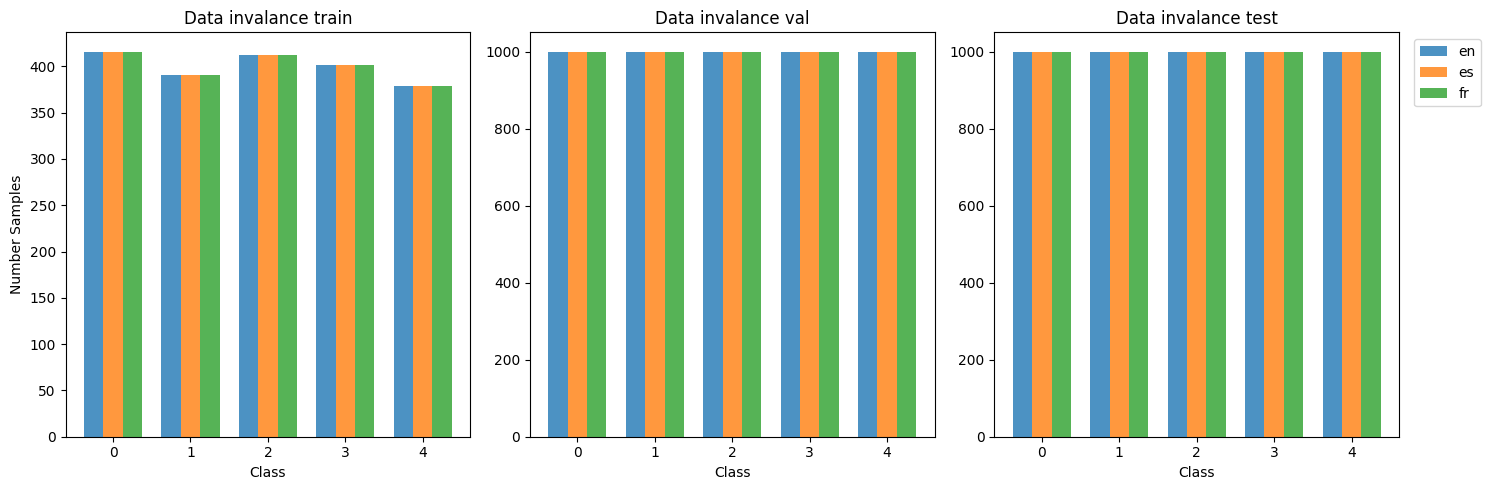

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
index = np.arange(num_labels)
bar_width = 0.25
opacity = 0.8
for i, (name_ds, ds) in enumerate(zip(["train", "val", "test"], [train_datasets, val_datasets, test_datasets])):
    for j, lang in enumerate(ALL_LANGS):
        objects, class_sample_counts=np.unique(ds[lang][target_key], return_counts=True)

        ax[i].bar(index + j*bar_width, class_sample_counts,
                        bar_width,
                        alpha=opacity,
                        label=lang)
        



        ax[i].set_xlabel('Class')
        if name_ds == "train":
            ax[i].set_ylabel('Number Samples')
        ax[i].set_title(f'Data invalance {name_ds}')
        ax[i].set_xticks(index+(len(ALL_LANGS)*bar_width)/2 -bar_width/2, range(num_labels))
        if name_ds == "test":
            ax[i].legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    
plt.tight_layout()
plt.show()

In [7]:
print("Num samples:", len(train_datasets["en"]))
print("Num labels:", num_labels)
assert len(set(frozenset(train_dataset.features.keys()) for train_dataset in train_datasets.values())) == 1
class2idx = train_datasets["en"].features[target_key].str2int

train_datasets["en"].features

Num samples: 2000
Num labels: 5


{'review_id': Value(dtype='string', id=None),
 'product_id': Value(dtype='string', id=None),
 'reviewer_id': Value(dtype='string', id=None),
 'stars': Value(dtype='int32', id=None),
 'review_body': Value(dtype='string', id=None),
 'review_title': Value(dtype='string', id=None),
 'language': Value(dtype='string', id=None),
 'product_category': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'class': ClassLabel(names=['0', '1', '2', '3', '4'], id=None)}

Get pararel anchors

In [8]:
anchor_dataset2num_samples = 1000
anchor_dataset2first_anchors = [
        776,
        507,
        895,
        922,
        33,
        483,
        85,
        750,
        354,
        523,
        184,
        809,
        418,
        615,
        682,
        501,
        760,
        49,
        732,
        336,
    ]


assert num_anchors <= anchor_dataset2num_samples

pl.seed_everything(42)
anchor_idxs = list(range(anchor_dataset2num_samples))
random.shuffle(anchor_idxs)
anchor_idxs = anchor_idxs[:num_anchors]

assert anchor_idxs[:20] == anchor_dataset2first_anchors  # better safe than sorry
lang2anchors = {
    lang: _amazon_translated_get_samples(lang=lang, sample_idxs=anchor_idxs) for lang in ALL_LANGS
}

Global seed set to 42


This is how we can handdle automatically the tokenizer

In [9]:
def collate_fn(batch, tokenizer, cls=True):
    data = []
    labels = []
    for sample in batch:
        data.append(sample[data_key])
        if cls:
            labels.append(sample[target_key])

    encoding = tokenizer(
        data,
        return_tensors="pt",
        return_special_tokens_mask=True,
        truncation=True,
        max_length=512,
        padding=True,
    )
    del encoding["special_tokens_mask"]

    if cls:
        result = (encoding, torch.tensor(labels))
    else:
        result = encoding

    return  result

def multi_draw_collate_fn(batch, tokenizer, cls=True):
    data = []
    labels = []    
    for x, y in batch:
        data += x 
        if cls:
            labels += [y]*len(x)

    encoding = tokenizer(
        data,
        return_tensors="pt",
        return_special_tokens_mask=True,
        truncation=True,
        max_length=512,
        padding=True,
    )
    del encoding["special_tokens_mask"]

    if cls:
        result = (encoding, torch.tensor(labels))
    else:
        result = encoding

    return  result

In [10]:
lang2transformer_name = {
    "en": "roberta-base",
    "es": "PlanTL-GOB-ES/roberta-base-bne",
    "fr": "ClassCat/roberta-base-french",
    #"ja": "nlp-waseda/roberta-base-japanese",
}
assert set(lang2transformer_name.keys()) == set(ALL_LANGS)

In [11]:
train_lang2dataloader = {}
test_lang2dataloader = {}
val_lang2dataloader = {}
anchors_lang2dataloader = {}

for lang in ALL_LANGS:
    transformer_name = lang2transformer_name[lang]
    print(transformer_name)
    lang_tokenizer = AutoTokenizer.from_pretrained(transformer_name)
    train_lang2dataloader[lang] = DataLoader(train_datasets[lang],
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       shuffle=True,
                                       pin_memory=True,
                                       drop_last=True,
                                       batch_size=16,
                                       )
    
    
    aux_test_ds = DictDataset(test_datasets[lang], data_key, target_key)
    ds_test_multi = IntraLabelMultiDraw(aux_test_ds, 16)
    test_lang2dataloader[lang] = (DataLoader(test_datasets[lang],
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       pin_memory=True
                                       ),
                                  DataLoader(ds_test_multi,
                                       num_workers=4,
                                       collate_fn=partial(multi_draw_collate_fn, tokenizer=lang_tokenizer, cls=False),
                                       batch_size=1,
                                       pin_memory=True
                                       )
                                 )
    
    
    val_lang2dataloader[lang] = DataLoader(val_datasets[lang],
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       pin_memory=True
                                       )
    
    anchors_lang2dataloader[lang] = DataLoader(lang2anchors[lang],
                                       num_workers=4,
                                       pin_memory=True,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer, cls=False),
                                       batch_size=48,
                                       )

roberta-base
PlanTL-GOB-ES/roberta-base-bne
ClassCat/roberta-base-french


# Train

In [12]:
from pl_modules.pl_roberta import LitRelRoberta

In [13]:
def test_model(model, dataloader, title=""):
    preds = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        batch_idx = 0
        for batch, _ in tqdm(dataloader, position=0, leave=True, desc="Computing"+title):
            batch.to(device)
            batch_latents = model(batch_idx=batch_idx, **batch)["prediction"].argmax(-1)
            preds.append(batch_latents)
            batch_idx = 1

    preds = torch.cat(preds, dim=0).detach().cpu().numpy()
    test_y = np.array(test_datasets["en"][target_key])

    precision, recall, fscore, _ = precision_recall_fscore_support(test_y, preds, average="weighted")
    mae = mean_absolute_error(y_true=test_y, y_pred=preds)
    acc = (preds == test_y).mean()
    return precision, recall, acc, fscore, mae

In [14]:
if linear:
    EPOCHS = 40
else:
    EPOCHS = 5 if fine_grained else 3


def train_network(lang, mode="relative", seed=24, fine_tune=False, test=False):
    
    # Create a PyTorch Lightning trainer with the generation callback
    
    if fine_grained:
        title = CHECKPOINT_PATH / 'fine_grained' 
    else:
        title = CHECKPOINT_PATH / 'coarse_grained' 
    
    if fine_tune:
        if linear:
            aux = "finetune_linear_"
        else:
            aux = "finetune_"
            
        title = title / f"{aux}{lang}_{mode}_seed{seed}"
    else:
        if linear:
            aux = "full_linear_"
        else:
            aux = "full_"
            
        title = title / f"{aux}_{lang}_{mode}_seed{seed}"
    
    trainer = pl.Trainer(default_root_dir=title, 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         accumulate_grad_batches=num_labels,
                         max_epochs=EPOCHS, 
                         check_val_every_n_epoch=1,
                         callbacks=[ModelCheckpoint(save_weights_only=True,
                                                   mode="max", monitor="val_acc",
                                                   filename="best"
                                                   ),
                                    ModelCheckpoint(save_weights_only=True,
                                                    filename="full"
                                                   ),
                                    LearningRateMonitor(logging_interval='step')
                                    ])
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    transformer_model = lang2transformer_name[lang]
    
    anchor_loader = None
    if mode == "relative":
        anchor_loader = anchors_lang2dataloader[lang]
    
    
    train_loader = train_lang2dataloader[lang]
    
    if fine_tune:
        freq_anchors = len(train_loader)
    else:
        
        freq_anchors = 100*num_labels if not linear else 10*num_labels
    
    model = LitRelRoberta(num_labels=num_labels,
                          transformer_model=transformer_model,
                          anchor_dataloader=anchor_loader,
                          hidden_size=num_anchors,
                          normalization_mode="batchnorm",
                          output_normalization_mode=None,
                          dropout_prob=0.1,
                          seed=seed,
                          steps=EPOCHS*len(train_loader),
                          weight_decay=0.01, 
                          head_lr=1e-3/num_labels,
                          encoder_lr=1.75e-4/num_labels,
                          layer_decay=0.65,
                          scheduler_act=True,
                          freq_anchors=freq_anchors,
                          device=device,
                          fine_tune=fine_tune,
                          linear=linear
                          )
    
    val_loader = val_lang2dataloader[lang]
    
    trainer.fit(model, train_loader, val_loader)
   
    if test:
        
        res = test_model(model.net, test_lang2dataloader[lang][0])
        with open("res.txt", "a") as f:
            f.write(f"-------------BASE {lang}-------------\n")
            f.write(f"precision {res[0]}\n")
            f.write(f"recall {res[1]}\n")
            f.write(f"acc {res[2]}\n")
            f.write(f"fscore {res[3]}\n")
            f.write(f"mae {res[4]}\n")
            
        print("precision", res[0])
        print("recall", res[1])
        print("acc", res[2])
        print("fscore", res[3])
        print("mae", res[4])
           
        if linear:
            aux = f"full_topo_dist_linear_clean_{lang}_{mode}_seed{seed}.png"
        else:
            aux = f"full_topo_dist_clean_{lang}_{mode}_seed{seed}.png"
        
        topo_model(model.net, device, test_lang2dataloader[lang][1],
                 FIG_PATH / "rel_vanilla" /
                 f"{'fine_grained' if fine_grained else 'coarse_grained'}/{aux}",
                 title=f"{lang.upper()} {mode}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                 pers="L_2", plot_topo=True, relative=mode=="relative");
       
    
    model.to("cpu")
    del model
    torch.cuda.empty_cache()

    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 1
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Typ

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
Computing: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:14<00:00, 10.85it/s]


precision 0.6129833956906857
recall 0.602
acc 0.602
fscore 0.6025827445991639
mae 0.4664


Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [03:47<00:00, 22.01it/s]


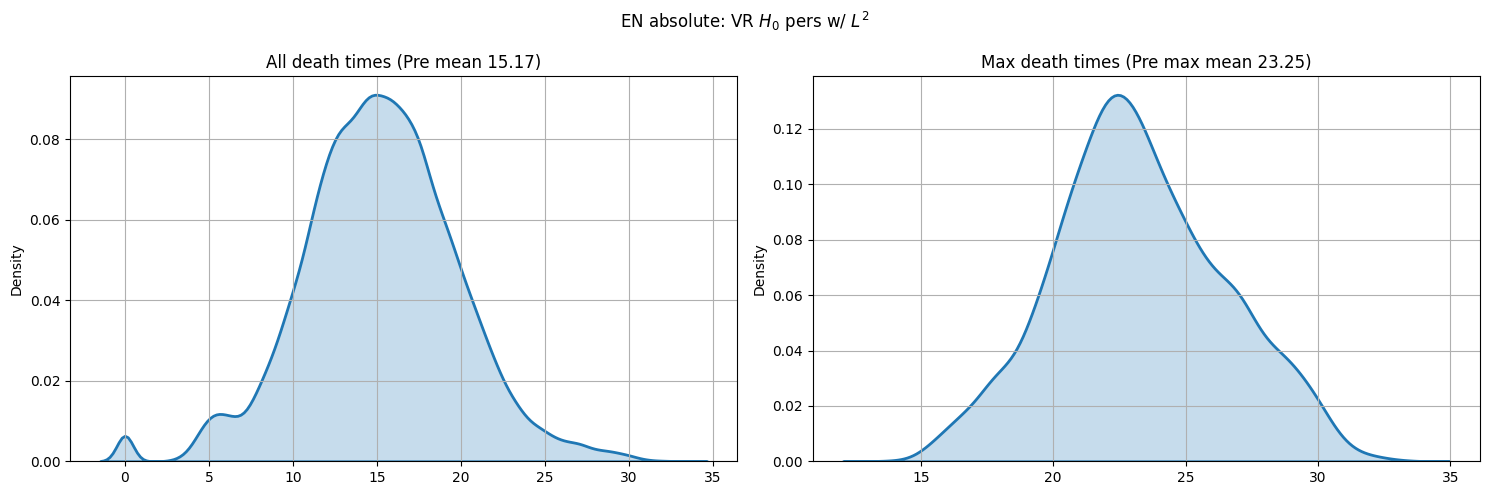

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
Some weights of the model checkpoint at ClassCat/roberta-base-french were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Missing logger folder: saved_models/rel_multi_vanilla/fine_grained/full_linear__fr_absolute_seed0/lightning_logs
LOCAL_RANK: 0 - CUDA_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
Computing: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:12<00:00, 12.58it/s]


precision 0.5226177675008197
recall 0.5164
acc 0.5164
fscore 0.5180276352238093
mae 0.5892


Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [03:20<00:00, 24.95it/s]


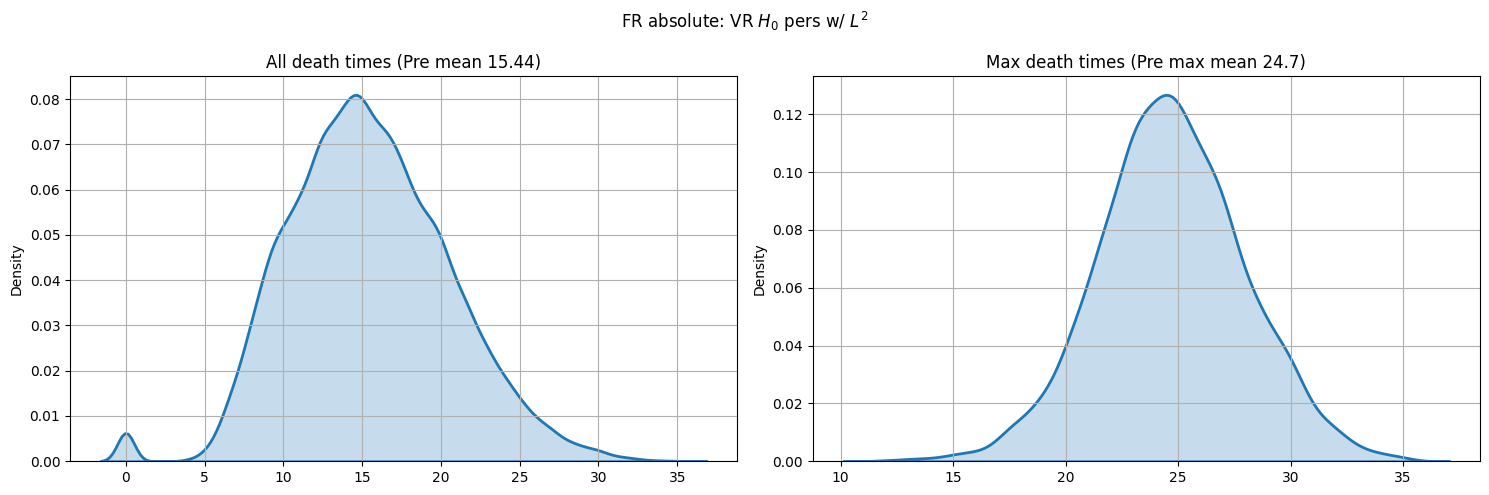

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 1
Some weights of the model checkpoint at ClassCat/roberta-base-french were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Missing logger folder: saved_models/rel_multi_vanilla/fine_grained/full_linear__fr_absolute_seed1/lightning_logs
LOCAL_RANK: 0 - CUDA_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
Computing: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:12<00:00, 12.58it/s]


precision 0.5123423794060218
recall 0.4884
acc 0.4884
fscore 0.49458668344129547
mae 0.6192


Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [03:18<00:00, 25.16it/s]


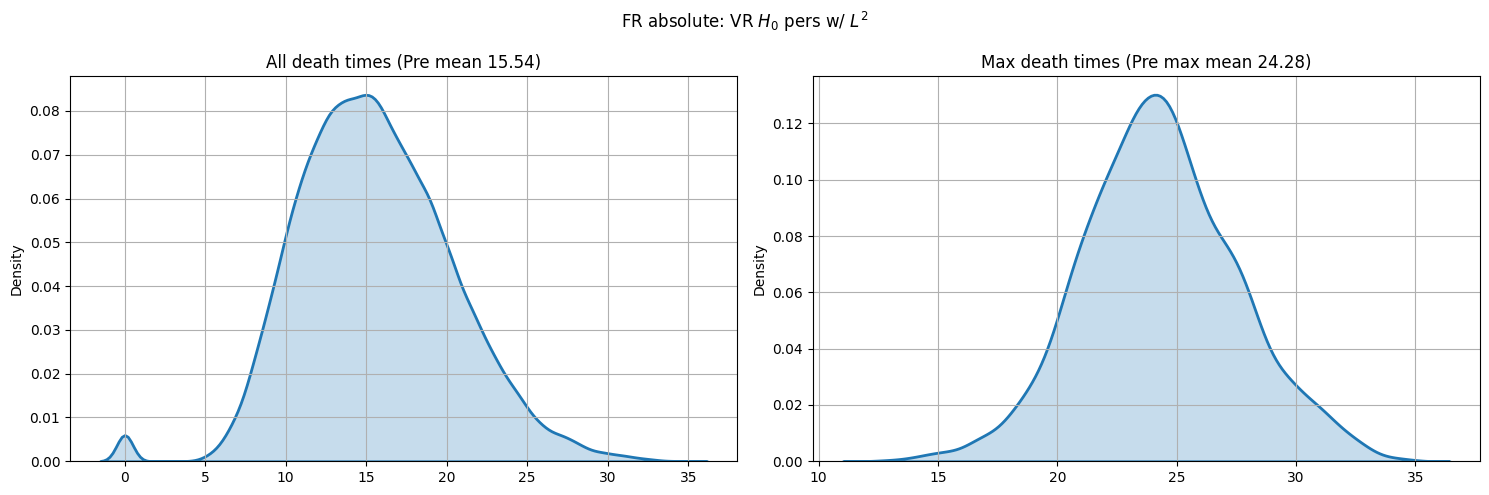

In [15]:
#train_network("en", mode="absolute", seed=0, fine_tune=False, test=True)
train_network("en", mode="absolute", seed=1, fine_tune=False, test=True)
train_network("fr", mode="absolute", seed=0, fine_tune=False, test=True)
train_network("fr", mode="absolute", seed=1, fine_tune=False, test=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Missing logger folder: saved_models/rel_multi_vanilla/fine_grain

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
Computing: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  8.97it/s]


precision 0.6125409044994504
recall 0.6102
acc 0.6102
fscore 0.6103040184617708
mae 0.4506


Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [04:22<00:00, 19.04it/s]


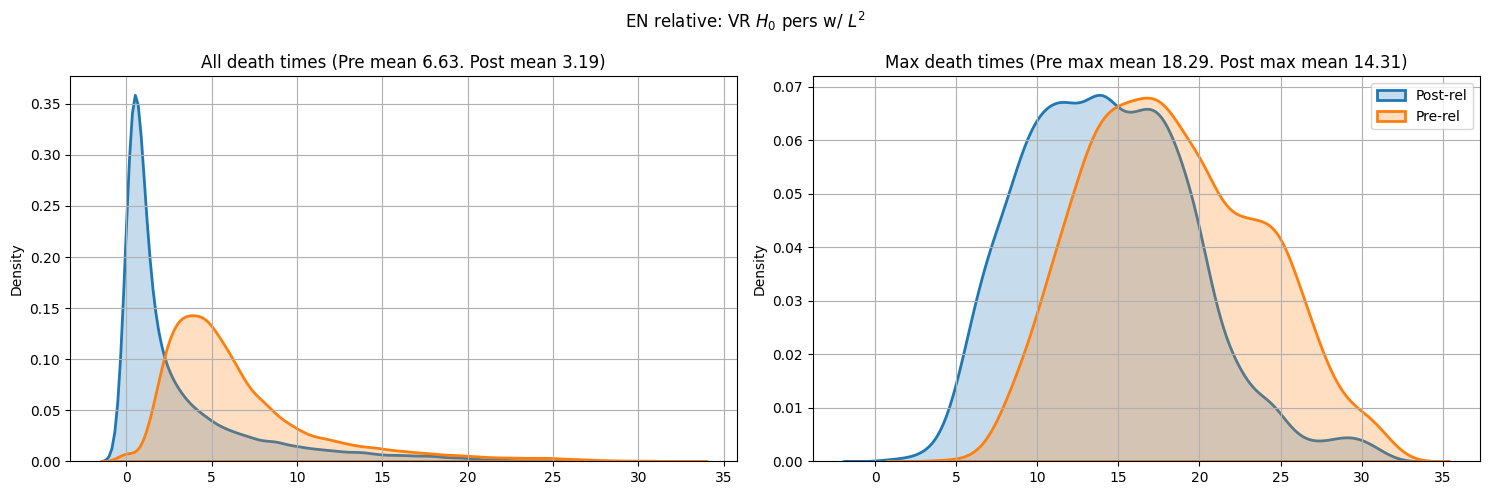

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 1
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Missing logger folder: saved_models/rel_multi_vanilla/fine_grain

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
Computing: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  8.97it/s]


precision 0.6161407349978636
recall 0.6054
acc 0.6054
fscore 0.6038826937151136
mae 0.4506


Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [04:20<00:00, 19.19it/s]


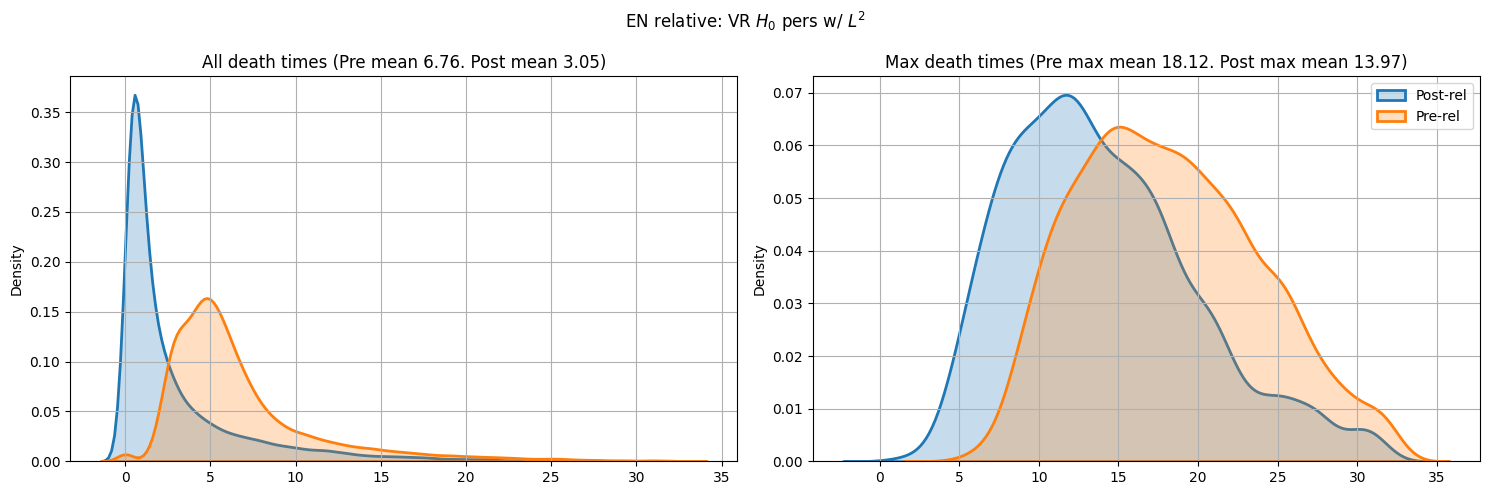

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0
Some weights of the model checkpoint at ClassCat/roberta-base-french were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Missing logger folder: saved_models/rel_multi_vanilla/fine_grained/full_linear__fr_relative_seed0/lightning_logs
LOCAL_RANK: 0 - CUDA_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
Computing: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:16<00:00,  9.73it/s]


precision 0.5291286447257803
recall 0.528
acc 0.528
fscore 0.528221308219057
mae 0.5658


Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [03:54<00:00, 21.33it/s]


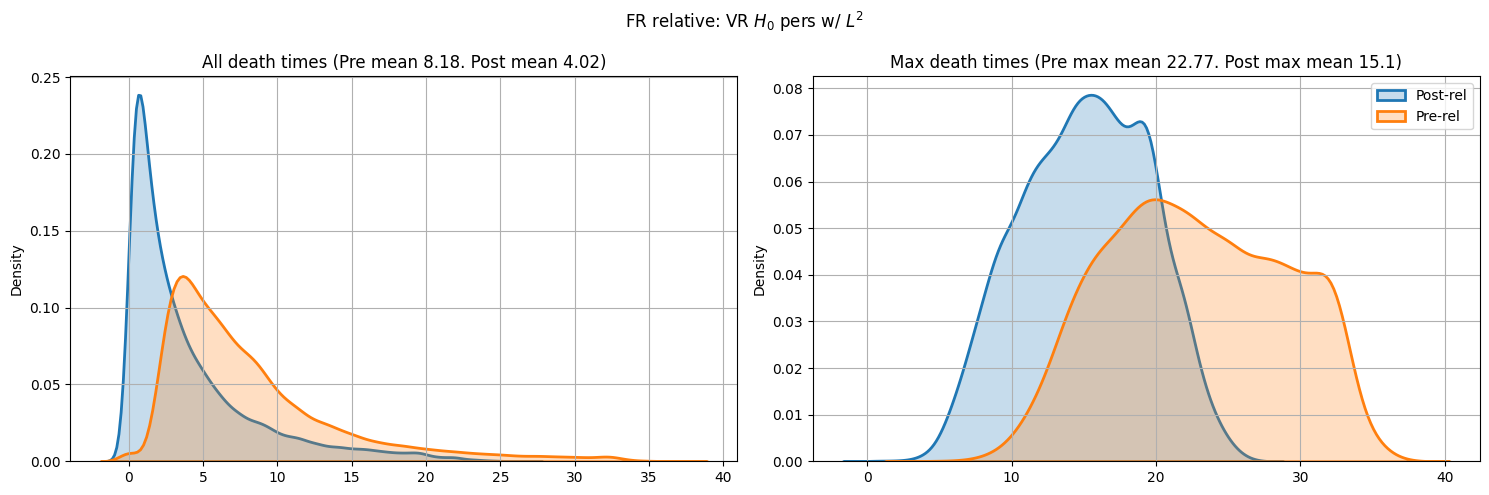

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 1
Some weights of the model checkpoint at ClassCat/roberta-base-french were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Missing logger folder: saved_models/rel_multi_vanilla/fine_grained/full_linear__fr_relative_seed1/lightning_logs
LOCAL_RANK: 0 - CUDA_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
Computing: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:16<00:00,  9.65it/s]


precision 0.5477940349982666
recall 0.5162
acc 0.5162
fscore 0.5235436384453837
mae 0.5648


Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [03:54<00:00, 21.37it/s]


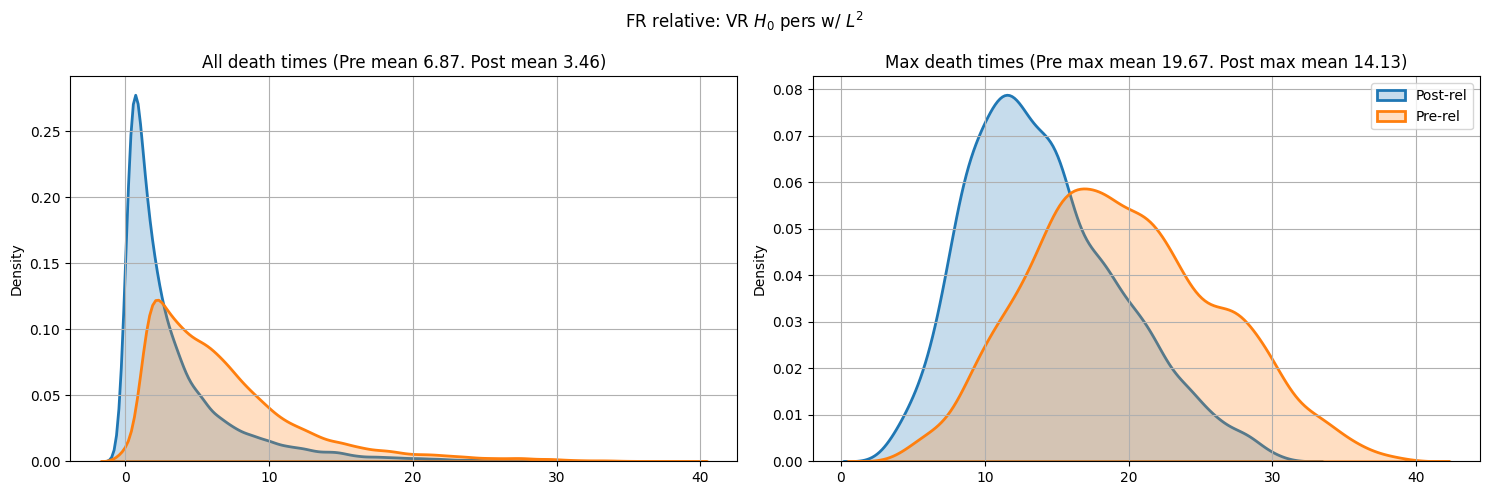

In [16]:
train_network("en", mode="relative", seed=0, fine_tune=False, test=True)
train_network("en", mode="relative", seed=1, fine_tune=False, test=True)
train_network("fr", mode="relative", seed=0, fine_tune=False, test=True)
train_network("fr", mode="relative", seed=1, fine_tune=False, test=True)

In [ ]:
SEEDS = [0, 1]
run = False

topo = True
if run:
    for seed in tqdm(SEEDS, leave=False, desc="seed"):
        for embedding_type in tqdm(["absolute"], leave=False, desc="embedding_type"):
            for mode in ["topo"]:
                for train_lang in tqdm(["en", "fr"], leave=False, desc="lang"):
                    model = LitTopoRelRoberta.load_from_checkpoint(
                                  CHECKPOINT_PATH / 
                                  f"{'fine_grained' if fine_grained else 'coarse_grained'}/{mode}_linear_{train_lang}_{embedding_type}_seed{seed}" /
                                  "lightning_logs/version_0/checkpoints/best.ckpt",
                                   linear=True)
                    
                    model = model.net
                    is_rel = embedding_type=="relative"
                    if is_rel:
                        model.anchor_dataloader = anchors_lang2dataloader[train_lang]


                    res = test_model(model, test_lang2dataloader[train_lang][0])
                    with open("res.txt", "a") as f:
                        f.write(f"-------------###-------------\n")

                        f.write(f"precision {res[0]}\n")
                        f.write(f"recall {res[1]}\n")
                        f.write(f"acc {res[2]}\n")
                        f.write(f"fscore {res[3]}\n")
                        f.write(f"mae {res[4]}\n")


                    print("precision", res[0])
                    print("recall", res[1])
                    print("acc", res[2])
                    print("fscore", res[3])
                    print("mae", res[4])
                    topo_model(model, device, test_lang2dataloader[train_lang][1],
                     FIG_PATH / f"rel_{mode}"/
                     f"{'fine_grained' if fine_grained else 'coarse_grained'}/best_topo_dist_{train_lang}_{embedding_type}_seed{seed}.png",
                     title=f"{train_lang.upper()} {embedding_type}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                     pers="L_2", plot_topo=True, relative=is_rel);


In [14]:
SEEDS = [1]
TRAIN = False

if TRAIN:
    for seed in tqdm(SEEDS, leave=False, desc="seed"):
        for fine_tune in tqdm([True, False], leave=False, desc="fine_tune"):
            for embedding_type in tqdm(["relative"], leave=False, desc="embedding_type"):
                for train_lang in tqdm(ALL_LANGS, leave=False, desc="lang"):
                    train_network(train_lang, mode=embedding_type, seed=seed, fine_tune=fine_tune)
                    clear_output(wait=True)

# Results

## Compute

In [16]:
numeric_results = {
    "finetune": {
        "seed": [],
        "embed_type": [],
        "enc_lang": [],
        "dec_lang": [],
        "precision": [],
        "recall": [],
        "acc": [],
        "fscore": [],
        "mae": [],
        "stitched": [],
        "CKA_pre":[],
        "CKA_post":[],
    },
     "full": {
        "seed": [],
        "embed_type": [],
        "enc_lang": [],
        "dec_lang": [],
        "precision": [],
        "recall": [],
        "acc": [],
        "fscore": [],
        "mae": [],
        "stitched": [],
        "CKA_pre":[],
        "CKA_post":[],
    },
}

pers = "L_2"
langs= ["en", "fr"]
embeddings = ["absolute"]
modes = ["finetune", "full"],
                      

for seed in [0]:
    models = {
        train_mode: {
            embedding_type: {
                    train_lang: LitRelRoberta.load_from_checkpoint(
                                  CHECKPOINT_PATH / 
                                  f"{'fine_grained' if fine_grained else 'coarse_grained'}/{train_mode}_{train_lang}_{embedding_type}_seed{seed}" /
                                  f"lightning_logs/version_0/checkpoints/best.ckpt", 
                                  linear=linear)

                    for train_lang in langs
                }
                for embedding_type in embeddings
        }
        for train_mode in tqdm(modes, leave=True, desc="mode")
    }
    
    for mode in modes:
        for embed_type in embeddings:
            for enc_lang  in langs:
                for dec_lang  in langs:
                    
                    model_enc = models[mode][embed_type][enc_lang].net
                    if embed_type == "relative":
                        model_enc.anchor_dataloader = anchors_lang2dataloader[enc_lang]
                        
                    if enc_lang != dec_lang:
                        model_dec = models[mode][embed_type][dec_lang].net
                        model = StitchingModule(model_enc, model_dec)
                    else:
                        model= model_enc
                      
                        
                    # The data is paired with its encoder
                    test_loader = test_lang2dataloader[enc_lang][0]
                    title = f" {mode}_seed{seed}_{embed_type}_{enc_lang}_{dec_lang}"
                    
                    
                    precision, recall, acc, fscore, mae = test_model(model, test_loader, title)
                    if j>i:
                        if relative:
                            model_dec.anchor_dataloader = anchors_lang2dataloader[dec_lang]

                        res = compare_topo_models(model_enc, model_dec, device,
                                            dataloader1=test_lang2dataloader[enc_lang][1],
                                            dataloader2=test_lang2dataloader[dec_lang][1],
                                            save_path= FIG_PATH / "rel_vanilla" /
                                                        f"{'fine_grained' if fine_grained else 'coarse_grained'}/topo_dist_{enc_lang}_{dec_lang}_{embed_type}_seed{seed}.png",
                                            title=f"{enc_lang.upper()}-{dec_lang.upper()} {embed_type}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                                            pers_fn=pers,
                                            plot=True,
                                            relative=relative,
                                            )
                        if relative:
                            numeric_results[mode]["CKA_pre"].append(res[0])
                            numeric_results[mode]["CKA_post"].append(res[1])
                        else:
                            numeric_results[mode]["CKA_pre"].append(res)
                            numeric_results[mode]["CKA_post"].append(-1.)

                    elif j<i:
                        numeric_results[mode]["CKA_pre"].append(numeric_results[mode]["CKA_pre"][i + j*len(langs)])
                        numeric_results[mode]["CKA_post"].append(numeric_results[mode]["CKA_post"][i + j*len(langs)])
                    else:
                        numeric_results[mode]["CKA_pre"].append(1.)
                        if relative:
                            numeric_results[mode]["CKA_post"].append(1.)
                        else:
                            numeric_results[mode]["CKA_post"].append(-1.)
                    
                    
                    precision, recall, acc, fscore, mae = test_model(model, test_loader, title)
                    numeric_results[mode]["embed_type"].append(embed_type)
                    numeric_results[mode]["enc_lang"].append(enc_lang)
                    numeric_results[mode]["dec_lang"].append(dec_lang)
                    numeric_results[mode]["precision"].append(precision)
                    numeric_results[mode]["recall"].append(recall)
                    numeric_results[mode]["acc"].append(acc)
                    numeric_results[mode]["fscore"].append(fscore)
                    numeric_results[mode]["stitched"].append(enc_lang != dec_lang)
                    numeric_results[mode]["mae"].append(mae)
                    numeric_results[mode]["seed"].append(seed)
    
    for mode in ["finetune", "full"]:
        for embed_type in ["absolute", "relative"]:
            for enc_lang  in ALL_LANGS:
                   del models[mode][embed_type][enc_lang]
                    


mode:   0%|                                                                              | 0/2 [00:00<?, ?it/s]Global seed set to 0
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Global seed set to 0
Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used

Global seed set to 0
Some weights of the model checkpoint at ClassCat/roberta-base-french were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Computing finetune_seed0_absolute_en_es: 100%|███████████████████████████████| 157/157 [00:14<00:00, 10.83it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

In [17]:
for mode in ["finetune", "full"]:
    df = pd.DataFrame(numeric_results[mode])
    
    df_2 = pd.read_csv(
        RESULT_PATH / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-{mode}-{train_perc}.tsv",
        sep='\t')
    
    df = pd.concat([df, df_2])
    
    df.to_csv(
        RESULT_PATH / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-{mode}-{train_perc}.tsv",
        sep="\t",
        index=False
    )

## View

In [18]:
fine_grained: bool = True

df_fine, tex_fine = process_df(fine_grained=fine_grained, mode="finetune", path=RESULT_PATH)

print(tex_fine)

df_fine

\begin{table}[ht]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{clcccccc}
\toprule
   &    & \multicolumn{3}{c}{Absolute} & \multicolumn{3}{c}{Relative} \\
 \cmidrule(lr){3-5} 
 \cmidrule(lr){6-8} 
 Decoder & Encoder & Acc & FScore & MAE & Acc & FScore & MAE \\
\midrule
\multirow{3}{*}{en} & en &  $55.67 \pm 0.58$ &  $54.96 \pm 1.86$ &    $53.80 \pm 2.55$ &  $55.06 \pm 0.82$ &  $54.33 \pm 1.13$ &   $55.69 \pm 2.33$ \\
   & es &  $18.80 \pm 1.61$ &   $8.14 \pm 2.06$ &  $191.49 \pm 12.12$ &  $44.59 \pm 0.16$ &  $42.44 \pm 0.59$ &   $79.93 \pm 0.27$ \\
   & fr &  $21.30 \pm 0.82$ &  $17.04 \pm 3.28$ &   $143.92 \pm 3.71$ &  $41.61 \pm 1.09$ &  $38.86 \pm 0.73$ &   $92.23 \pm 3.69$ \\
&\\
\multirow{3}{*}{es} & en &  $18.64 \pm 1.78$ &   $6.57 \pm 0.11$ &   $207.14 \pm 9.42$ &  $41.63 \pm 1.43$ &  $39.98 \pm 1.35$ &  $101.07 \pm 7.57$ \\
   & es &  $54.18 \pm 0.51$ &  $53.80 \pm 0.50$ &    $54.67 \pm 1.23$ &  $51.46 \pm 0.31$ &  $49.79 \pm 0.27$ &   $61.15 \pm 0.35$ \\
   & fr &  $2

Absolute                                   Relative        \
                     acc       fscore           mae             acc         
                    mean   std   mean   std    mean    std     mean   std   
Decoder Encoder                                                             
en      en         55.67  0.58  54.96  1.86   53.80   2.55    55.06  0.82   
        es         18.80  1.61   8.14  2.06  191.49  12.12    44.59  0.16   
        fr         21.30  0.82  17.04  3.28  143.92   3.71    41.61  1.09   
es      en         18.64  1.78   6.57  0.11  207.14   9.42    41.63  1.43   
        es         54.18  0.51  53.80  0.50   54.67   1.23    51.46  0.31   
        fr         21.01  0.41  12.19  0.45  193.09   2.28    39.88  0.88   
fr      en         20.16  0.23   9.04  3.36  131.96  11.37    43.29  1.94   
        es         20.15  0.27   9.77  0.17  139.57   5.44    40.95  0.13   
        fr         49.12  1.24  48.86  1.00   63.76   0.28    46.39  1.09   

                                            
                fscore           mae        
                  mean   std    mean   std  
Decoder Encoder                             
en      en       54.33  1.13   55.69  2.33  
        es       42.44  0.59   79.93  0.27  
        fr       38.86  0.73   92.23  3.69  
es      en       39.98  1.35  101.07  7.57  
        es       49.79  0.27   61.15  0.35  
        fr       36.33  2.00   99.27  2.98  
fr      en       42.66  1.56   80.38  2.09  
        es       38.51  0.08   92.40  0.99  
        fr       45.26  1.98   74.25  4.17

In [19]:
df_full, tex_full = process_df(fine_grained=fine_grained, mode="full", path=RESULT_PATH)

print(tex_full)
df_full

\begin{table}[ht]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{clcccccc}
\toprule
   &    & \multicolumn{3}{c}{Absolute} & \multicolumn{3}{c}{Relative} \\
 \cmidrule(lr){3-5} 
 \cmidrule(lr){6-8} 
 Decoder & Encoder & Acc & FScore & MAE & Acc & FScore & MAE \\
\midrule
\multirow{3}{*}{en} & en &   $65.33 \pm 0.49$ &   $65.22 \pm 0.10$ &    $39.49 \pm 0.33$ &  $64.64 \pm 0.42$ &  $64.67 \pm 0.04$ &  $39.51 \pm 0.52$ \\
   & es &  $11.64 \pm 10.30$ &    $8.65 \pm 6.27$ &  $224.77 \pm 37.46$ &  $59.15 \pm 0.27$ &  $58.87 \pm 0.32$ &  $45.68 \pm 0.25$ \\
   & fr &   $17.99 \pm 2.81$ &   $11.89 \pm 0.22$ &  $172.37 \pm 12.57$ &  $56.44 \pm 0.91$ &  $55.57 \pm 1.92$ &  $50.25 \pm 1.88$ \\
&\\
\multirow{3}{*}{es} & en &   $12.41 \pm 2.93$ &   $10.94 \pm 0.39$ &   $233.60 \pm 5.69$ &  $62.43 \pm 1.00$ &  $61.50 \pm 1.66$ &  $43.19 \pm 3.01$ \\
   & es &   $59.42 \pm 0.11$ &   $59.31 \pm 0.01$ &    $44.76 \pm 0.37$ &  $59.22 \pm 0.62$ &  $58.65 \pm 0.66$ &  $45.80 \pm 0.71$ \\
   & fr 

Absolute                                     Relative        \
                     acc        fscore            mae             acc         
                    mean    std   mean    std    mean    std     mean   std   
Decoder Encoder                                                               
en      en         65.33   0.49  65.22   0.10   39.49   0.33    64.64  0.42   
        es         11.64  10.30   8.65   6.27  224.77  37.46    59.15  0.27   
        fr         17.99   2.81  11.89   0.22  172.37  12.57    56.44  0.91   
es      en         12.41   2.93  10.94   0.39  233.60   5.69    62.43  1.00   
        es         59.42   0.11  59.31   0.01   44.76   0.37    59.22  0.62   
        fr         18.37   8.08  16.44  10.91  164.08  37.17    56.03  0.41   
fr      en         23.82   0.76  21.22   3.49  142.57  24.03    64.77  0.52   
        es         13.85  10.48  11.15   6.95  188.00  46.22    59.06  0.17   
        fr         56.33   0.13  56.02   0.56   50.22   0.34    56.21  0.44   

                                           
                fscore          mae        
                  mean   std   mean   std  
Decoder Encoder                            
en      en       64.67  0.04  39.51  0.52  
        es       58.87  0.32  45.68  0.25  
        fr       55.57  1.92  50.25  1.88  
es      en       61.50  1.66  43.19  3.01  
        es       58.65  0.66  45.80  0.71  
        fr       54.30  0.62  51.30  0.40  
fr      en       64.59  0.18  39.56  0.34  
        es       58.90  0.46  45.74  0.40  
        fr       55.72  1.43  50.67  1.77